### Import needed libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Import dataset

In [2]:
# Set initial variables
mask_data_dir = "./data/trainvalidate/WithMask/"
nomask_data_dir = "./data/trainvalidate/WithoutMask/"
img_height = img_width = desired_size = 100
img_channels = 3
initialdata = []
labels = []
shapes = []

# Import images
for filename in os.listdir(mask_data_dir):
    img=cv2.imread(mask_data_dir+filename, cv2.IMREAD_COLOR)
    initialdata.append(img)
    labels.append(1)
    shapes.append(img.shape)
    
for filename in os.listdir(nomask_data_dir):
    img=cv2.imread(nomask_data_dir+filename, cv2.IMREAD_COLOR)
    initialdata.append(img)
    labels.append(0)
    shapes.append(img.shape)

print(f"The toal number of images is: {len(initialdata)}")

The toal number of images is: 6802


### Show sample images

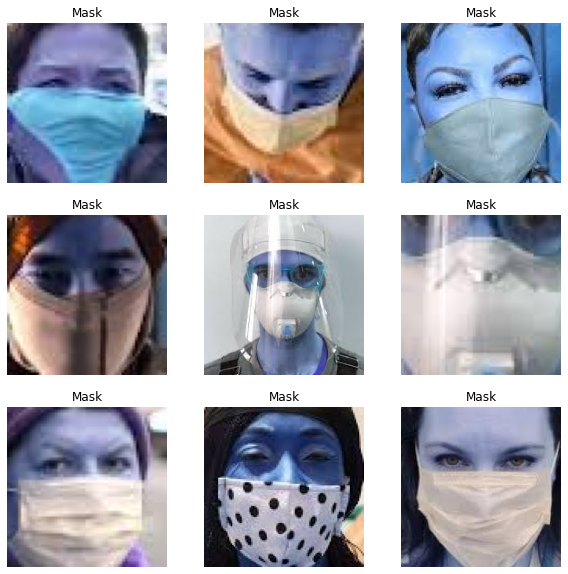

In [3]:
maskdict = ["No Mask", "Mask"]
plt.figure(figsize=(10, 10))
for i in range(10,19):
    ax = plt.subplot(3, 3, i + 1 -10)
    plt.imshow(initialdata[i].astype("uint8"))
    plt.title(maskdict[labels[i]])
    plt.axis("off")

### Check the shape of the images

In [4]:
#Get smallest and biggest dimensions
smallestheight = biggestheight = shapes[0][0]
smallestwidth = biggestwidth = shapes[0][1]
for shape in shapes:
    if shape[0] < smallestheight:
        smallestheight = shape[0]
    if shape[0] > biggestheight:
        biggestheight = shape[0]
    if shape[1] < smallestwidth:
        smallestwidth = shape[1]
    if shape[1] > biggestwidth:
        biggestwidth = shape[1]

print(f"The smallest height: {smallestheight}")
print(f"The smallest width: {smallestwidth}")
print(f"The biggest height: {biggestheight}")
print(f"The biggest width: {biggestwidth}")
        
#Check if any images are not rectangular 
for shape in shapes:
    if shape[0] != shape[1]:
        print("Some images are not rectangular")
        break

The smallest height: 25
The smallest width: 25
The biggest height: 563
The biggest width: 563


### Resize images , using 0 padding to maintain aspect ratio

In [5]:
# convert imported images into desired size
data = []
for im in initialdata:
    old_size = im.shape[:2]
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    new_im = cv2.resize(im, (new_size[1], new_size[0]), interpolation=cv2.INTER_CUBIC)

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(new_im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    data.append(new_im)

### Split dataset to Train, Validate, and Test sets

In [6]:
#Split data between train, validation, and test 
trainvalid_data, test_data, trainvalid_label, test_label = train_test_split(data, labels, test_size=0.05)
train_data, valid_data, train_label, valid_label = train_test_split(trainvalid_data, trainvalid_label, test_size=0.2)

#Convert lists back to numpy array
train_data = np.asarray(train_data)
valid_data = np.asarray(valid_data)
test_data = np.asarray(test_data)
train_label = np.asarray(train_label)
valid_label = np.asarray(valid_label)
test_label = np.asarray(test_label)

### Show count of each set then plot histogram

Dataset        Total Size     Without Mask   With Mask      
Total          6802           5909 (87.0%)   893 (13.0%)    
Training       5168           4485 (87.0%)   683 (13.0%)    
Validation     1293           1123 (87.0%)   170 (13.0%)    
Test           341            301 (88.0%)    40 (12.0%)     


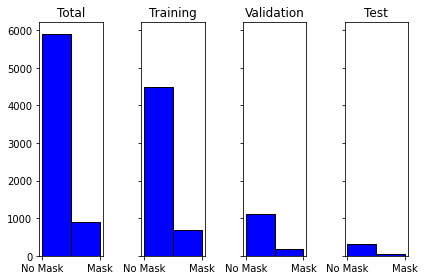

In [7]:
# Show table for count in each dataset
tableheader = ["Dataset", "Total Size", "Without Mask", "With Mask"]
tabledata = list()
format_row = "{:<15}" * (len(tableheader))
print(format_row.format(*tableheader))

labeldict = {"Total": labels, "Training": train_label, "Validation": valid_label, "Test": test_label}
for key in labeldict:
    total = len(labeldict[key])
    count_no_mask = count_with_mask = 0
    for label in labeldict[key]: 
        if label == 0: count_no_mask+=1
    count_with_mask = total-count_no_mask
    tabledata.append((str(key), str(total), str(count_no_mask) + " (" + str(round(count_no_mask/total, 2)*100) +"%)", str(count_with_mask) + " (" + str(round(count_with_mask/total, 2)*100) +"%)"))
    
for row in tabledata:
    print(format_row.format(*row))

# Plot the histogram
fig, axs = plt.subplots(1, len(labeldict), sharey=True, tight_layout=True)
graphnumber = 0
for key in labeldict:
    axs[graphnumber].set_title(str(key))
    axs[graphnumber].hist(labeldict[key], bins=2, color = 'blue', edgecolor = 'black')
    axs[graphnumber].set_xticks([0,1])
    axs[graphnumber].set_xticklabels(maskdict)
    graphnumber += 1


### Enable memory storage and prefetch (Disabling this for now, may use later)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Set the arguments(may use Grid Search later)

In [8]:
epochs=3
batch_size=100

### Data Augmentation

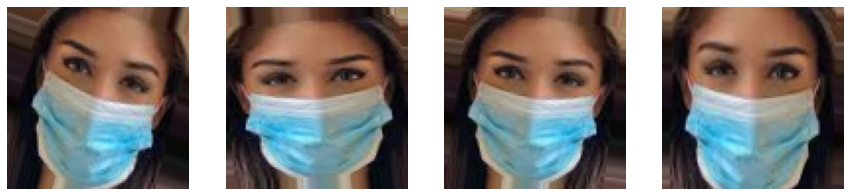

In [9]:
datagenerator = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

#datagenerator.fit(train_data)

# Print sample of augmented image
image = load_img('data/trainvalidate/WithMask/148.png')
image_array = np.expand_dims(img_to_array(image), 0)
aug_iter = datagenerator.flow(image_array, batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')

### Model 1: Build and train (2 Conv Layers, No Data Aug)

In [17]:
model1=Sequential()
model1.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,img_channels)))
model1.add(layers.Conv2D(16,(3,3),activation='relu',padding='same'))
model1.add(layers.MaxPooling2D(pool_size=(2,2)))
model1.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
model1.add(layers.MaxPooling2D(pool_size=(2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(128,activation='relu'))
#model1.add(layers.BatchNormalization())
model1.add(layers.Dense(1,activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

history1 = model1.fit(train_data, train_label, batch_size=batch_size, 
                    epochs=epochs, validation_data=(valid_data,valid_label))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)        9280      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 40000)            

### Model 2: Build and train (2 Conv Layers, With Data Aug)

In [18]:
model2=Sequential()
model2.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,img_channels)))
model2.add(layers.Conv2D(16,(3,3),activation='relu',padding='same'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128,activation='relu'))
#model2.add(layers.BatchNormalization())
model2.add(layers.Dense(1,activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

history2 = model2.fit(datagenerator.flow(train_data, train_label,batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=len(train_data) / batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / batch_size)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 50, 50, 64)        9280      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 40000)            

### Model 3: Build and train (3 Conv Layers, No Data Aug)

In [19]:
model3=Sequential()
model3.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
model3.add(layers.Conv2D(16,(3,3),activation='relu',padding='same'))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.Conv2D(32,(3,3),activation='relu',padding='same'))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128,activation='relu'))
#model3.add(layers.BatchNormalization())
model3.add(layers.Dense(1,activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

history3 = model3.fit(train_data, train_label, batch_size=batch_size, 
                    epochs=epochs, validation_data=(valid_data,valid_label))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 64)       

### Model 4: Build and train (3 Conv Layers, With Data Aug)

In [20]:
model4=Sequential()
model4.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
model4.add(layers.Conv2D(16,(3,3),activation='relu',padding='same'))
model4.add(layers.MaxPooling2D(pool_size=(2,2)))
model4.add(layers.Conv2D(32,(3,3),activation='relu',padding='same'))
model4.add(layers.MaxPooling2D(pool_size=(2,2)))
model4.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
model4.add(layers.MaxPooling2D(pool_size=(2,2)))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(128,activation='relu'))
#model4.add(layers.BatchNormalization())
model4.add(layers.Dense(1,activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model4.summary()

history4 = model4.fit(datagenerator.flow(train_data, train_label,batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=len(train_data) / batch_size, 
                    validation_data=(valid_data,valid_label), validation_steps=len(valid_data) / batch_size)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 64)       

### Plot Model Training and Validation Accuracy and Loss

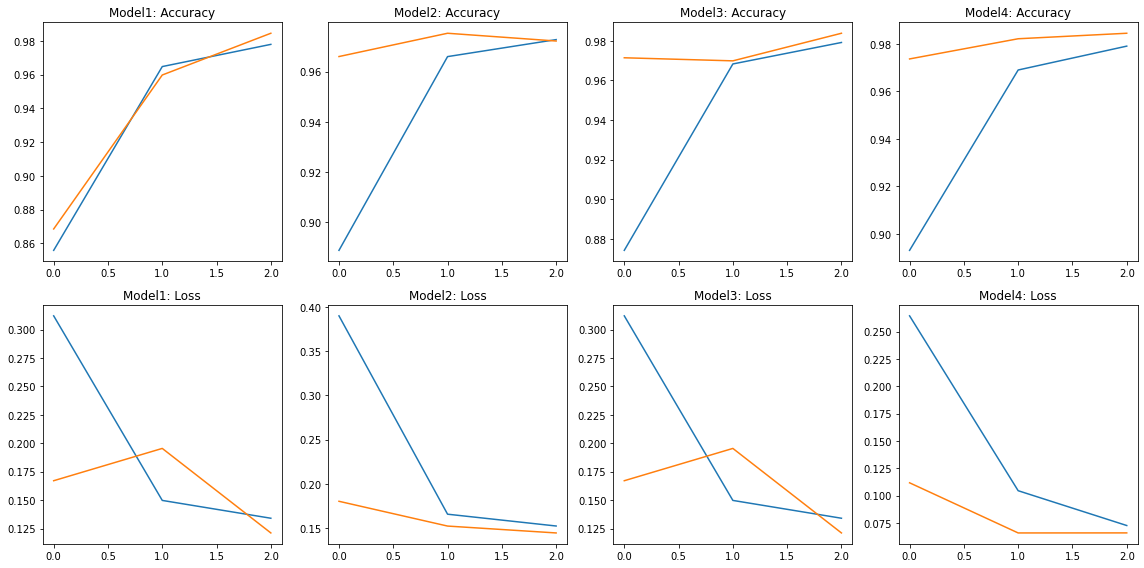

In [21]:
acc1 = history1.history['accuracy']
acc2 = history2.history['accuracy']
acc3 = history3.history['accuracy']
acc4 = history4.history['accuracy']

val_acc1 = history1.history['val_accuracy']
val_acc2 = history2.history['val_accuracy']
val_acc3 = history3.history['val_accuracy']
val_acc4 = history4.history['val_accuracy']

loss1 = history1.history['loss']
loss2 = history2.history['loss']
loss3 = history3.history['loss']
loss4 = history4.history['loss']

val_loss1 = history1.history['val_loss']
val_loss2 = history2.history['val_loss']
val_loss3 = history3.history['val_loss']
val_loss4 = history4.history['val_loss']

epochs_range = range(epochs)

fig, axs = plt.subplots(2, 4, constrained_layout=False, figsize=(16, 8))

axs[0,0].set_title('Model1: Accuracy')
axs[0,0].plot(epochs_range, acc1, label='Training Accuracy')
axs[0,0].plot(epochs_range, val_acc1, label='Validation Accuracy')

axs[0,1].set_title('Model2: Accuracy')
axs[0,1].plot(epochs_range, acc2, label='Training Accuracy')
axs[0,1].plot(epochs_range, val_acc2, label='Validation Accuracy')

axs[0,2].set_title('Model3: Accuracy')
axs[0,2].plot(epochs_range, acc3, label='Training Accuracy')
axs[0,2].plot(epochs_range, val_acc3, label='Validation Accuracy')

axs[0,3].set_title('Model4: Accuracy')
axs[0,3].plot(epochs_range, acc4, label='Training Accuracy')
axs[0,3].plot(epochs_range, val_acc4, label='Validation Accuracy')

axs[1,0].set_title('Model1: Loss')
axs[1,0].plot(epochs_range, loss1, label='Training Loss')
axs[1,0].plot(epochs_range, val_loss1, label='Validation Loss')

axs[1,1].set_title('Model2: Loss')
axs[1,1].plot(epochs_range, loss2, label='Training Loss')
axs[1,1].plot(epochs_range, val_loss2, label='Validation Loss')

axs[1,2].set_title('Model3: Loss')
axs[1,2].plot(epochs_range, loss1, label='Training Loss')
axs[1,2].plot(epochs_range, val_loss1, label='Validation Loss')

axs[1,3].set_title('Model4: Loss')
axs[1,3].plot(epochs_range, loss4, label='Training Loss')
axs[1,3].plot(epochs_range, val_loss4, label='Validation Loss')

fig.tight_layout()

### Test the Models

In [43]:
# Perform tests
score1, acc1 = model1.evaluate(test_data, test_label, batch_size=100)
score2, acc2 = model2.evaluate(test_data, test_label, batch_size=100)
score3, acc3 = model3.evaluate(test_data, test_label, batch_size=100)
score4, acc4 = model4.evaluate(test_data, test_label, batch_size=100)

# Print test results in table
tableheader = ["Model #", "Accuracy"]
tabledata = list()
format_row = "{:<15}" * (len(tableheader))
print(format_row2.format(*tableheader))
tabledata.append(("Model 1", str(acc1)))
tabledata.append(("Model 2", str(acc2)))
tabledata.append(("Model 3", str(acc3)))
tabledata.append(("Model 4", str(acc2)))
for row in tabledata:
    print(format_row.format(*row))

4/4 [==============================] - 0s 80ms/step - loss: 0.0518 - accuracy: 0.9883
Model #        Accuracy       
Model 1        0.9794721603393555
Model 2        0.9765396118164062
Model 3        0.9824047088623047
Model 4        0.9765396118164062
